In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys 
sys.path.append("../..")

from cge_modeling import Variable, Parameter, Equation, CGEModel
import pandas as pd
import numpy as np

In [3]:
data = pd.read_csv('../data/lesson_6_sam.csv', index_col=[0, 1], header=[0, 1]).fillna(0.0)
assert (data.sum(axis=0) - data.sum(axis=1) == 0).all()

sectors = data.loc['Activity'].index.tolist()

coords = {
    'i':sectors,
    'j':sectors
}

In [24]:
# Model Variables
variables = [
    # Prices
    Variable('P', dims='i', description='Purchaser price of <dim:i> goods'),
    Variable('P_Y', dims='i', description='Producer price of <dim:i> final good'),

    Variable('P_DT', extend_subscript=1, dims='i', description='Price of domestic <dim:i> Armington bundle'),
    Variable('P_D', extend_subscript=1, dims='i', description='Price of domestic <dim:i> goods in Armington bundle'), 

    Variable('P_W_M', extend_subscript=2, dims='i', description='World price of imported <dim:i> goods'),
    Variable('P_M', extend_subscript=2, dims='i', description='Domestic price of imported <dim:i> goods'),

    Variable('P_W_Ex', extend_subscript=2, dims='i', description='World price of exported <dim:i> goods'),
    Variable('P_Ex', extend_subscript=2, dims='i', description='Domestic price of exported <dim:i> goods'),
 
    Variable('P_VA', extend_subscript=1, dims='i', description='Price of value add bundle in <dim:i> sector'),
    Variable('P_VC', extend_subscript=1, dims='i', description='Price of value chain bundle in <dim:i> sector'),
 
    Variable('r', description='Rental rate of capital'),

    # Production
    Variable('Y', dims='i', description='Total output of <dim:i> sector'),
    Variable('VA', dims='i', description='Value add bundle (KL) produced by <dim:i>'),
    Variable('VC', dims='i', description='Value chain bundle (intermediate consumption) produced by <dim:i>'),
    Variable('K_d', dims='i', description='<dim:i> demand for capital'),
    Variable('L_d', dims='i', description='<dim:i> demand for labor'),
    Variable('X', dims=('i', 'j'), description='<dim:i> goods demanded by <dim:j>'),

    Variable('D_s', dims='i', description='<dim:i> firm supply to domestic market'),
    Variable('Ex', dims='i', description='World demand for <dim:i> sector exports'),

    # Household
    Variable('income', latex_name=r'\Omega', description='Household pre-tax income'),
    Variable('disp_income', latex_name=r'\hat{\Omega}', description='Household after-tax income'),
    Variable('C', dims='i', description='Consumption of <dim:i> goods'),
    Variable('U', description='Household utility'),
    
    # Investment
    Variable('I_d', dims='i', description='<dim:i> demand for investment'),
    Variable('I_s', description='Total savings'),
    Variable('S', description='Household savings'),

    # Government
    Variable('G', description='Government spending'),
    Variable('C_G', dims='i', extend_subscript=1, description='Government demand for <dim:i> goods'),
    
    # Other
    Variable('DT', dims='i', description='Domestic absorbtion in <dim:i> market'),
    Variable('D_d', dims='i', description='Total domestic demand for <dim:i> goods'),
    Variable('resid', latex_name='\varepsilon', description='Walrasian residual'),
    
    # Rest of World
    Variable('M', dims='i', description='World supply of <dim:i> sector imports'),
    # Var('TB', description='Trade balance'),
    Variable('e', description='Exchange rate')
]

parameters = [
    # Large country assumption
    Parameter('Ex_bar', latex_name='\bar{X}', dims='i', 
              description='World equlibrium demand for <dim:i> sector exports'),
    Parameter('sigma_Ex', dims='i', 
              description='Elasticity of world <dim:i> export demand'),
    Parameter('M_bar', latex_name='\bar{M}', dims='i',
              description='World equlibrium supply of <dim:i> sector imports'),
    Parameter('sigma_M', dims='i',
              description='Elasticity of world <dim:i> import supply'),

    # Production functions
    Parameter('psi_VA', dims='i', extend_subscript=1,
              description='Share of value add bundle in <dim:i> final output'),
    Parameter('psi_VC', dims='i', extend_subscript=1,
              description='Share of value chain bundle in <dim:i> final output'),
    Parameter('A', dims='i', description='<dim:i> total factor productivity'),
    Parameter('alpha', dims='i', description='Share of capital in <dim:i> production process'),
    Parameter('psi_X', extend_subscript=1, dims=('i', 'j'), description='Share of <dim:i> goods in <dim:j> value chain bundle'),

    # CET supply allocation
    Parameter('A_Ex', extend_subscript=1, dims='i', 
              description='<dim:i> TFP of production allocation in export market'),
    Parameter('A_XD', extend_subscript=1, dims='i', 
              description='<dim:i> TFP of production allocation in domestic market'),
    Parameter('sigma_CET', extend_subscript=1, dims='i', 
              description='<dim:i> elasticity of allocation between domestic and export markets'),

    # Armington bundle
    Parameter('A_D', extend_subscript=1, dims='i', 
              description='<dim:i> TFP of Armington bundling for domestic goods'),
    Parameter('A_M', extend_subscript=1, dims='i', 
              description='<dim:i> TFP of Armington bundling for imported goods'),
    Parameter('sigma_DT', extend_subscript=1, dims='i',
              description='<dim:i> elasticity of substitution between domestic and imported variety'),
    
    # Investment
    Parameter('alpha_I', dims='i', description='Share of total investment capital demanded by <dim:i>'),
    
    # Taxes
    Parameter('tau_P', dims='i', description='Sales tax on purchases of <dim:i> sector goods'),
    Parameter('tau_M', dims='i', description='Import duty on <dim:i> sector goods'),
    Parameter('tau_income', latex_name='\tau_\Omega', description='Income tax'),

    # Household
    Parameter('mpc', latex_name='phi', description='Marginal propensitiy to consume'),
    Parameter('gamma', dims='i', description='Share of <dim:i> in household consumption'),
    Parameter('L_s', extend_subscript=1, description='Household supply of labor'),
    Parameter('K_s', description='Household supply of capital'),

    # Government
    Parameter('alpha_G', extend_subscript=1, dims='i', 
              description='Share of <dim:i> goods in government expenditure'),
    
    # Model closure
    Parameter('G_S', description='Goverment surplus'),
    Parameter('w', description='Wage level'), # Numeraire
    # Parameter('e', desc='Exchange rate')
    Parameter('TB', description='Trade Balance'),

]

equations = [
    # Price Block
    Equation('<dim:i> purchaser price',
             'P = P_DT * (1 + tau_P)'),
    Equation('<dim:i> domestic import good price',
             'P_M = e * P_W_M * (1 + tau_M)'),
    Equation('<dim:i> domestic export good price',
             'P_Ex = e * P_W_Ex'),

    # Large country assumption
    Equation('World demand for <dim:i> sector exports', 'Ex = Ex_bar * P_W_Ex ** (-sigma_Ex)'),
    Equation('World supply of <dim:i> sector imports', 'M = M_bar * P_W_M ** sigma_M'),

    # Production
    Equation('<dim:i> demand for value add bundle', 'VA = psi_VA * Y'),
    Equation('<dim:i> demand for value chain bundle', 'VC = psi_VC * Y'),
    Equation('Value of total <dim:i> output', 'P_Y * Y = P_VA * VA + P_VC * VC'),

    Equation('<dim:i> production of value add bundle', 'VA = A * K_d ** alpha * L_d ** (1 - alpha)'),
    Equation('<dim:i> demand for capital', 'K_d = alpha * VA * P_VA / r'),
    Equation('<dim:i> demand for labor', 'L_d = (1 - alpha) * VA * P_VA / w'),
    
    Equation('Value of <dim:j> value chain bundle', 
             'P_VC * VC = (P[:, None] * X).sum(axis=0)'),
    Equation('<dim:j> demand for <dim:i> final goods', 'X = psi_X * VC'),

    # Firm supply allocation between local and exports
    Equation('Value of total <dim:i> sales', 
             'P_Y * Y = P_Ex * Ex + P_D * D_s'),
    Equation('<dim:i> output allocated to export market',
             'Ex = A_Ex * Y * (P_Ex / P_Y) ** sigma_CET'),
    Equation('<dim:i> output allocated to domestic market',
             'D_s = A_XD * Y * (P_D / P_Y) ** sigma_CET'),

    # Firm demand for investment capital
    Equation('<dim:i> demand for investment capital', 
             'I_d * P = alpha_I * I_s'),
    
    # Household
    Equation('Household income', 'income = w * L_s + r * K_s'),
    Equation('Household net income', 'disp_income = (1 - tau_income) * income'),
    Equation('Household savings', 'S = (1 - mpc) * disp_income'),
    Equation('Household demand for <dim:i>', 
             'C * P = gamma * mpc * disp_income'),
    Equation('Household utility', 'U = (C ** gamma).prod()'),

    # Government
    Equation('Government budget constraint', 
             'G + G_S = tau_income * income + (tau_P * P_DT * DT).sum() + (tau_M * e * P_W_M * M).sum()'),
    Equation('Government demand for <dim:i> goods',
             'C_G * P = alpha_G * G'),
    
    # Market clearing
    Equation('Labor market clearing', 'L_s = L_d.sum() + resid'),
    Equation('Capital market clearing', 'K_s = K_d.sum()'),
    Equation('<dim:i> domestic goods market clearing', 'D_s = D_d'),
    Equation('Macroeconomic equlibrium', 'TB = S + G_S - I_s'),
    
    # Absorbtion
    Equation('<dim:i> domestic absorbtion', 
             'DT = C + X.sum(axis=1) + I_d + C_G'),

    # Armington bundling at the border
    Equation('Total value of <dim:i> Armington bundle',
             'P_DT * DT = P_D * D_d + P_M * M'),
    Equation('Demand for domestic goods in <dim:i> Armington bundle',
             'D_d = A_D * DT * (P_DT / P_D) ** sigma_DT'),
    Equation('Demand for imported goods in <dim:i> Armington bundle',
             'M = A_M * DT * (P_DT / P_M) ** sigma_DT'),
    
    # Trade balance
    Equation('Trade Balance', 'TB = e * (P_W_Ex * Ex - P_W_M * M).sum()')
]

In [25]:
mod = CGEModel(
    variables=variables,
    parameters=parameters,
    equations=equations,
    coords=coords,
    parse_equations_to_sympy=False,
    use_scan_euler=False,
    backend="pytensor",
    mode="JAX",
    use_sparse_matrices=False,
    compile=['euler', 'root'],
)

Initializing variables
Initializing parameters
Initializing equations
Initial pre-processing complete, found 87 equations, 87 variables, 73 parameters
Beginning compilation using pytensor backend using JAX mode
Compiling model with ['euler', 'root'] functions
Compiling model equations into pytensor graph
Compiling CGE equations into JAX function
Compiling Jacobian equations into JAX function
Compiling euler approximation function


In [26]:
def initialize_parameter(name, mod, value=3.0):
    dims = mod.get(name).dims
    size = [len(mod.coords[dim]) for dim in dims]
    return np.full(size, value)

In [27]:
import_duties_collected = np.array([0., 300., 0.])
initial_values = {
    'import_collected': import_duties_collected,
    'K_d': data.loc[('Factor', 'Capital'), 'Activity'],
    'L_d': data.loc[('Factor', 'Labor'), 'Activity'],
    'C_G': data.loc['Commodity', ('Institution', 'Government')],
    'Y': data.loc[[('Institution', 'Government')] +[('Activity', x) for x in coords['i']], 'Commodity'].sum() - import_duties_collected,
    'I_d': data.loc['Commodity', ('Other', 'Capital Investment')],
    'sales_tax_revenue': data.loc[('Institution', 'Government'), 'Commodity'] - import_duties_collected,
    'C': data.loc['Commodity', ('Institution', 'Household')],
    'income_tax_revenue': data.loc[('Institution', 'Government'), ('Institution', 'Household')],
    'S': data.loc[('Other', 'Capital Investment'), ('Institution', 'Household')],
    'X': data.loc['Commodity', 'Activity'],
    'M': data.loc[('Other', 'Rest of World'), 'Commodity'] + import_duties_collected,
    'Ex': data.loc['Commodity', ('Other', 'Rest of World')]
}
econometric_estimates = {
    'sigma_Ex':initialize_parameter('sigma_Ex', mod, 100),
    'sigma_M':initialize_parameter('sigma_M', mod, 100),
    'sigma_CET':initialize_parameter('sigma_CET', mod),
    'sigma_DT':initialize_parameter('sigma_DT', mod)
}

In [28]:
def check_shape(data, name, mod):
    obj = mod.get(name)
    dims = obj.dims
    shape = tuple([len(mod.coords[i]) for i in dims])
    if data.shape != shape:
        print(f'{name} has shape {data.shape}, expected {shape}')

In [29]:
def calibrate(mod, *, 
              import_collected, 
              K_d, 
              L_d, 
              C_G,
              Y, 
              I_d, 
              sales_tax_revenue,
              C, 
              income_tax_revenue, 
              S, 
              X, 
              M, 
              Ex,
              sigma_Ex, 
              sigma_M, 
              sigma_CET, 
              sigma_DT):

    P_D = initialize_parameter('P_D', mod, 1.)
    P_M = initialize_parameter('P_M', mod, 1.)
    P_Ex = initialize_parameter('P_Ex', mod, 1.)
    P_VA = initialize_parameter('P_VA', mod, 1.)
    P_VC = initialize_parameter('P_VC', mod, 1.)
    P = initialize_parameter('P', mod, 1.)
    r = initialize_parameter('r', mod, 1.)
    w = initialize_parameter('w', mod, 1.)
    e = initialize_parameter('e', mod, 1.)

    L_s = L_d.sum()
    K_s = K_d.sum()

    tau_P = sales_tax_revenue / (P * Y - sales_tax_revenue)

    VC = (P * X).sum(axis=0) / P_VC
    VA = (w * L_d + r * K_d) / P_VA
    P_Y = (P_VA * VA + P_VC * VC) / Y
    
    D_s = (P_Y * Y - P_Ex * Ex) / P_D
    D_d = D_s

    P_DT = P / (1 + tau_P)
    DT = C + C_G + I_d + X.sum(axis=1)
    P_M = (P_DT * DT - P_D * D_d) / M

    alpha = r * K_d / (P_VA * VA)
    A = VA / (L_d ** (1 - alpha) * K_d ** alpha)

    income = w * L_s + r * K_s
    tau_income = income_tax_revenue / income
    disp_income = (1 - tau_income) * income
    G = (P * C_G).sum()
    alpha_G = P * C_G / G

    A_Ex = (Ex / Y) * (P_Ex / P_Y) ** (-sigma_CET)
    A_XD = (D_s / Y) * (P_D / P_Y) ** (-sigma_CET)
    A_D = (D_d / DT) * (P_DT / P_D) ** (-sigma_DT)
    A_M = (M / DT) * (P_DT / P_M) ** (-sigma_DT)

    tau_M = import_collected / (P_M * M - import_collected)
    P_W_M = P_M / (e * (1 + tau_M))
    P_W_Ex = e * P_Ex

    Ex_bar = Ex / (P_W_Ex ** (-sigma_Ex))
    M_bar = M / (P_W_M ** sigma_M)

    TB = e * (P_W_Ex * Ex - P_W_M * M).sum()

    psi_VA = VA / Y
    psi_VC = VC / Y
    psi_X = X / VC.values[None]

    G_S = tau_income * income + (tau_P * DT * P_DT).sum() + (tau_M * P_W_M * e * M).sum() - G
    
    I_s = (P * I_d).sum()
    alpha_I = P * I_d / I_s
    mpc = 1 - S / disp_income
    gamma = P * C / (mpc * disp_income)
    U = (C ** gamma).prod()
    resid = S - I_s + G_S - TB
    
    d = {}
    for obj in sorted(mod.variables) + sorted(mod.parameters):
        if obj.name != "_" and obj.name in locals():
            data = locals()[obj.name]
            if isinstance(data, (pd.DataFrame, pd.Series)):
                data = data.values
            d[obj.name] = data
            check_shape(data, obj.name, mod)
        else:
            print(f"{obj.name} not found in model variables")

    return d

In [30]:
calibrated_data = calibrate(mod, **initial_values, **econometric_estimates)

In [31]:
mod.check_for_equilibrium(calibrated_data)

Equilibrium found! Total squared error: 0.000000


In [32]:
tax_cut = mod.simulate(
    initial_state=calibrated_data,
    final_values={'tau_M':np.array([0, 0, 0])},
    use_optimizer=True,
    use_euler_approximation=True,
    n_iter_euler=10_000,
    optimizer_mode='root',
    method='hybr',
)

In [33]:
import cge_modeling.plotting as cgp

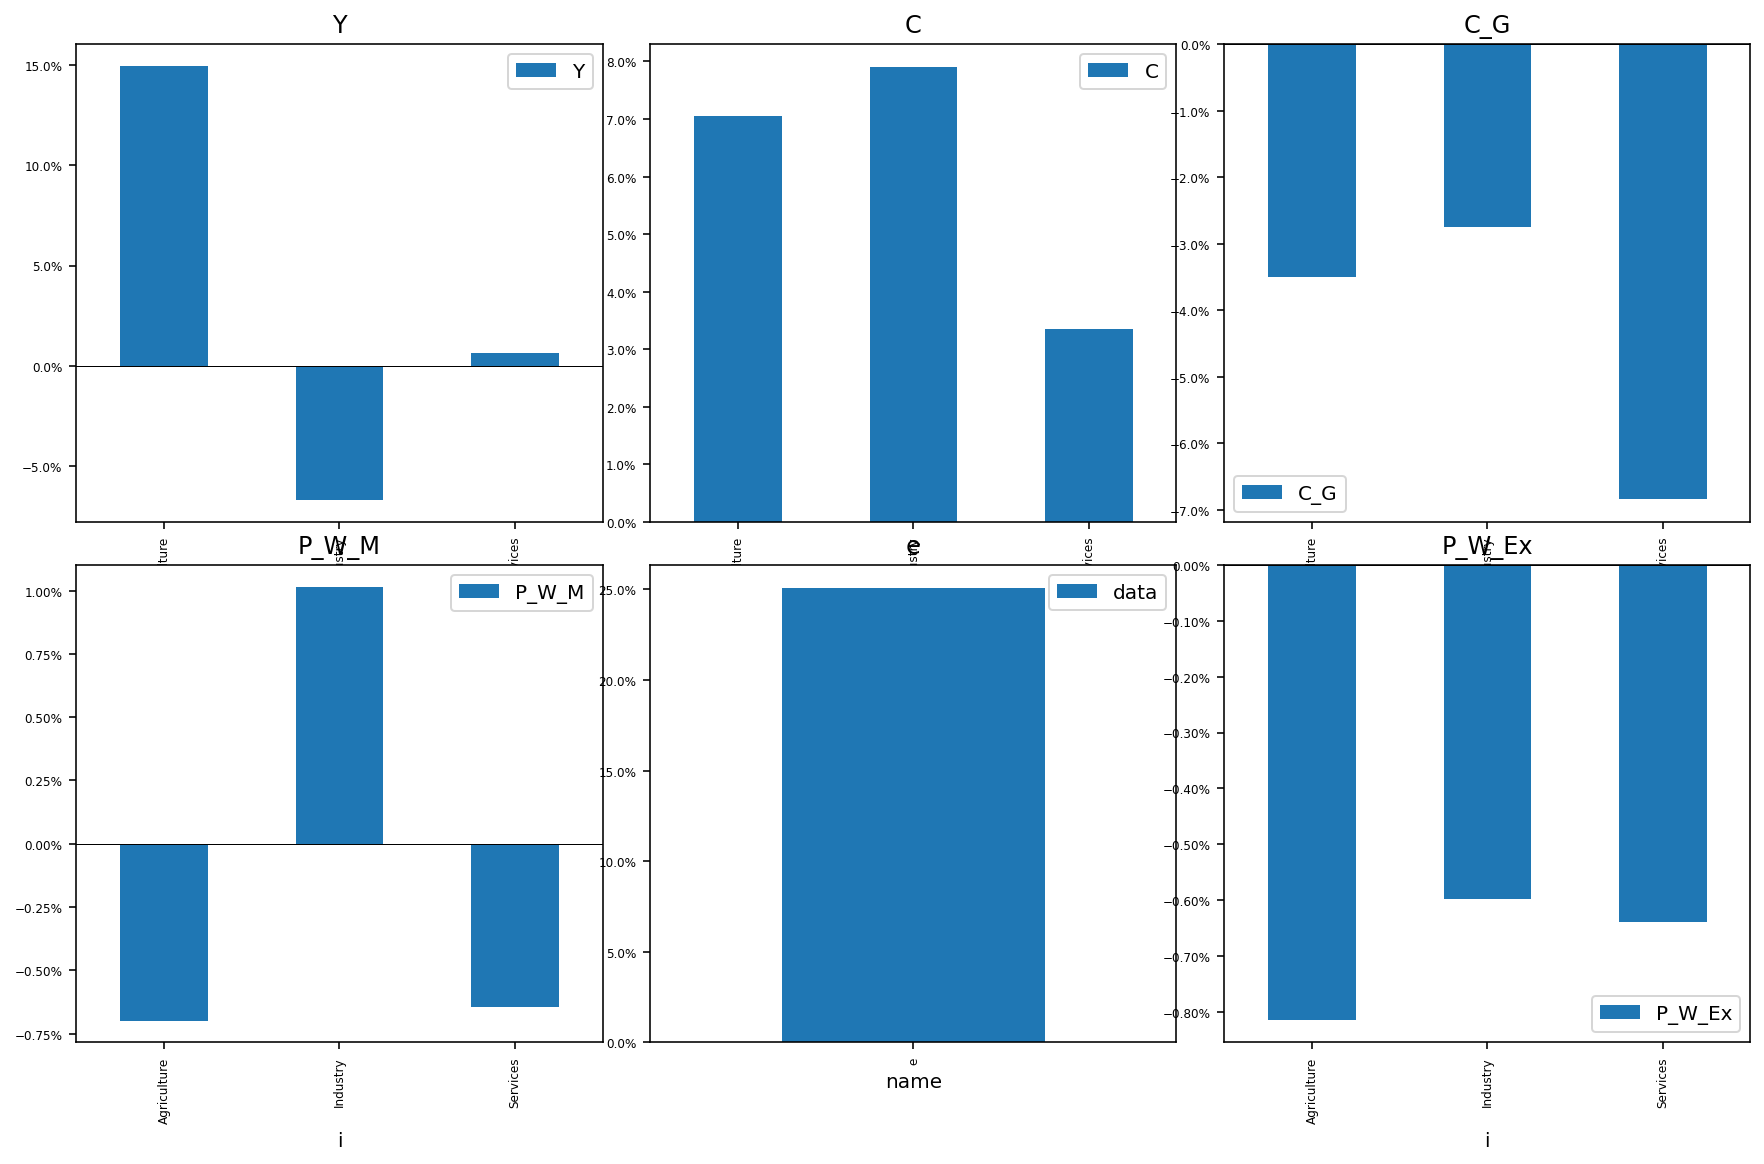

In [39]:
cgp.plot_bar(tax_cut, mod, ['Y', 'C', 'C_G', 'P_W_M', 'e', 'P_W_Ex'], metric='pct_change');

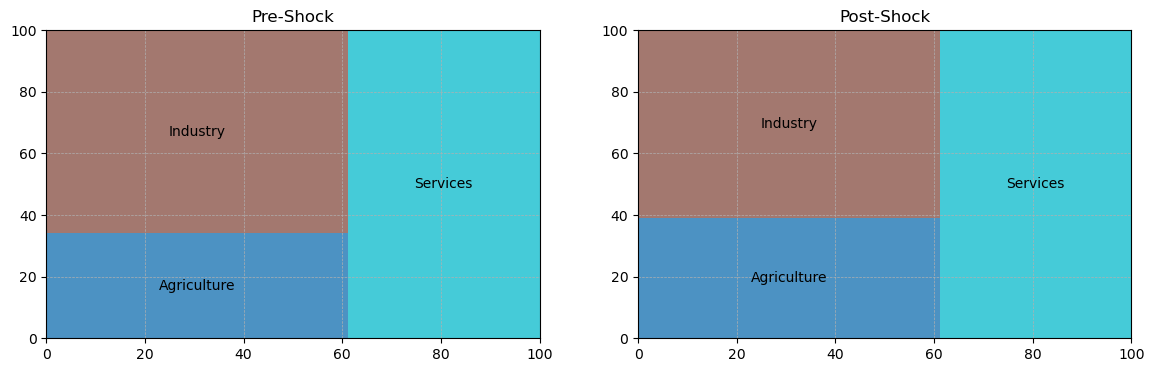

In [23]:
cgp.plot_kateplot(tax_cut, calibrated_data, mod, ['Y']);